In [1]:
import h5py
import deepdish as dd
from convergenets.utils import utils
from scripts.visualizations.helpers import load_weights
from tqdm import tqdm
from tqdm import trange

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import itertools
import deepdish as dd
from scipy.stats import norm as sp_norm
from sklearn.linear_model import LinearRegression


In [2]:
flags = ["overwrite"]
CACHE_PATH = "/mnt/fs6/jvrsgsty/neural-mechanics/jv_neural_mechanics"

def create_args_string(kwargs, flags, pre_command="python train.py", subset_keys=None):
    s = f"{pre_command} "
    if subset_keys is not None:
        kwargs = {k:v for k,v in kwargs.items() if k in subset_keys}
    for k, v in kwargs.items():
        s += f"--{k} {v} "
    for f in flags:
        s += f"--{f} "
    return s

In [3]:
def phase_3d(ax, x, v, time, xt=None, vt=None, timet=None,
             k=None, color="k"):
    if k is None:
        k = len(x)
        assert k == len(v)
        assert k > 0
        min_x = min(x[-k:])
        min_v = min(v[-k:])
        max_time = max(time[-k:])
    
    if xt is not None:
        kt = len(xt)
        min_x = min(min_x, min(xt[-kt:]))
        min_v = min(min_v, min(vt[-kt:]))
        max_time = max(max_time, max(timet[-kt:]))
    
    # Empirical
    ax.plot(x[-k:], time, v[-k:], lw=1, color="k")
    ax.plot(x[-k:], time, min_v * np.ones(k), color="k", alpha=0.25)
    ax.plot(min_x * np.ones(k), time, v[-k:], color="k", alpha=0.25)
    ax.plot(x[-k:], max_time*np.ones(k), v[-k:], color="k", alpha=0.25)
    
    # Theory
    if xt is not None and vt is not None and timet is not None:
        ax.plot(xt[-kt:], timet, vt[-kt:], lw=1, color="r")
        ax.plot(xt[-kt:], timet, min_v * np.ones(kt), color="r", alpha=0.25)
        ax.plot(min_x * np.ones(kt), timet, vt[-kt:], color="r", alpha=0.25)
        ax.plot(xt[-kt:], max_time*np.ones(kt), vt[-kt:], color="r", alpha=0.25)
    
    # Labels
    ax.set_xlabel("Position")
    ax.set_ylabel("Time")
    ax.set_zlabel("Velocity")
    ax.view_init(elev=35.0, azim=-35)
    # This line just scales the axis in the figure: x,y,z,1.0 by the constants in the np.diag
    # Unsure why we have 0.75 in the last component
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 2, 1.5, 2]))
    #plt.tight_layout()
    # plt.savefig('bias-oscillations-3d.png', format='png', bbox_inches='tight', transparent=True)

In [4]:
def mean(eigenvalue, a_init, b_init, lr, beta, lamb, time):

    gamma = (1-beta)/(lr*(1+beta))
    omega = np.sqrt(2/(lr*(1+beta))*(eigenvalue+lamb))
    if np.isnan(gamma):
        raise "Gamma is NaN"
    if np.isnan(omega):
        raise "Omega is NaN"
    
    if gamma < omega:
        freq = np.sqrt(omega**2 - gamma**2)
        a = np.exp(-gamma*time)*(a_init*np.cos(freq*time) + (gamma*a_init + b_init)/freq*np.sin(freq*time))
        b = np.exp(-gamma*time)*(b_init*np.cos(freq*time) - ((omega**2)*a_init+gamma*b_init)/freq*np.sin(freq*time))

    if gamma == omega:
        a = np.exp(-gamma*time)*(a_init + (gamma*a_init + b_init)*time)
        b = np.exp(-gamma*time)*(b_init - ((omega**2)*a_init+gamma*b_init) * time)

    if gamma > omega:
        freq = np.sqrt(gamma**2 - omega**2)
        a = np.exp(-gamma*time)*(a_init*np.cosh(freq*time) + (gamma*a_init + b_init)/freq*np.sinh(freq*time))
        b = np.exp(-gamma*time)*(b_init*np.cosh(freq*time) - ((omega**2)*a_init+gamma*b_init)/freq*np.sinh(freq*time))

    return a, b

def variance(eigenvalue, confidence, sigma, lr, beta, lamb, bs, time):
    def matrix_exponential(gamma, omega, t):
        A = np.zeros((2,2))
        if gamma < omega:
            delta = np.sqrt(omega**2 - gamma**2)
            A[0,0] = np.cos(delta*t) + gamma/delta*np.sin(delta*t)
            A[0,1] = 1/delta*np.sin(delta*t)
            A[1,0] = -omega**2/delta*np.sin(delta*t)
            A[1,1] = np.cos(delta*t) - gamma/delta*np.sin(delta*t)
        if gamma == omega:
            A[0,0] = 1 + gamma*t
            A[0,1] = t
            A[1,0] = -omega**2 * t
            A[1,1] = 1 - gamma*t
        if gamma > omega:
            delta = np.sqrt(gamma**2 - omega**2)
            A[0,0] = np.cosh(delta*t) + gamma/delta*np.sinh(delta*t)
            A[0,1] = 1/delta*np.sinh(delta*t)
            A[1,0] = -omega**2/delta*np.sinh(delta*t)
            A[1,1] = np.cosh(delta*t) - gamma/delta*np.sinh(delta*t) 
        A *= np.exp(-gamma*t)
        return A
    gamma = (1-beta)/(lr*(1+beta))
    omega = np.sqrt(2/(lr*(1+beta))*(eigenvalue+lamb))
    Di = np.zeros((2,2))
    Di[0,0] = lr/(2*bs*(1-beta))*eigenvalue/(eigenvalue+lamb)
    Di[1,1] = 1/(bs*(1-beta**2))*eigenvalue
    z = sp_norm.interval(confidence)[1]
    va = []
    vb = []
    for t in time:
        A = matrix_exponential(gamma, omega, t)
        variance = Di - A.dot(Di).dot(A.T)
        try:
            L = np.linalg.cholesky(variance)
        except np.linalg.LinAlgError:
            L = np.zeros_like(variance)
        va.append(L.dot(np.array([z,0]))[0])
        vb.append(L.dot(np.array([0,z]))[1])
    va = sigma**2 * np.array(va)
    vb = sigma**2 * np.array(vb)
    return va, vb

In [18]:
def load_cache(experiment="hessian", expid="imagenet_pret_ce", expid_eigenvalues=None, **kwargs):
    if expid_eigenvalues is None:
        expid_eigenvalues = expid
    PT_CACHE_DIR = "/mnt/fs6/jvrsgsty/neural-mechanics"
    traj_cache = f"{PT_CACHE_DIR}/{experiment}/{expid}/cache/pos_vel.h5"
    weights = dd.io.load(traj_cache, f"/metrics/position")
    grads = dd.io.load(traj_cache, f"/metrics/velocity")
    spectral_cache = f"{PT_CACHE_DIR}/{experiment}/{expid_eigenvalues}/metrics/spectral.h5"
    eigenvectors = dd.io.load(spectral_cache, f"/eigenvector")
    eigenvalues = dd.io.load(spectral_cache, f"/eigenvalues")
    eigen_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[eigen_idx]
    eigenvectors = eigenvectors[:,eigen_idx]
    assert weights.shape == grads.shape
    assert weights.shape[1] == eigenvectors.shape[0]
    return weights, grads, eigenvectors, eigenvalues
    
def project(weights, grads, eigenvectors,eig_idx = 0): 
    projected_weights = np.array(
        [np.dot(weights[i], eigenvectors[:, eig_idx]) for i in range(weights.shape[0])]
    )
    projected_grads = np.array(
        [np.dot(grads[i], eigenvectors[:, eig_idx]) for i in range(grads.shape[0])]
    )
    return projected_weights, projected_grads


## Some setup to create train scripts and keep track of kwargs

In [6]:
exp_kwargs = {
    "experiment": "nonlinear",
    "expid": "cifar10_fc2_evals",
    "save-dir": "/mnt/fs6/jvrsgsty/neural-mechanics",
    "dataset": "cifar10",
    "data-dir": "/mnt/fs6/jvrsgsty/data",
    "model-dir": "/mnt/fs6/jvrsgsty/pretrained_models",
    #"pretrained": True,
    "model": "vgg11",
    "model-class": "tinyimagenet",
    "loss": "mse",
    "optimizer": "custom_sgd",
    "test-batch-size": 256,
    "epochs": 0,
    "save-freq": 1, 
    "save-begin-epoch": 10,
    "eigenvector": True,
    "eigen-batch-size": 128,
    "power-iters": 10,
    "eigen-dims": 15,
    # Sweep ofer these
    "train-batch-size": 256,
    "lr": 0.01,
    "wd": 1e-4,
    "momentum": 0.9,
    "gpu": "8",
}
flags = ["overwrite"]
print(create_args_string(exp_kwargs, flags))

python train.py --experiment nonlinear --expid cifar10_fc2_evals --save-dir /mnt/fs6/jvrsgsty/neural-mechanics --dataset cifar10 --data-dir /mnt/fs6/jvrsgsty/data --model-dir /mnt/fs6/jvrsgsty/pretrained_models --model vgg11 --model-class tinyimagenet --loss mse --optimizer custom_sgd --test-batch-size 256 --epochs 0 --save-freq 1 --save-begin-epoch 10 --eigenvector True --eigen-batch-size 128 --power-iters 10 --eigen-dims 15 --train-batch-size 256 --lr 0.01 --wd 0.0001 --momentum 0.9 --gpu 8 --overwrite 


In [ ]:
lrs = [0.001, 0.0001, 0.00001]
lrs = [0.1, 0.01]
wds = [0, 1e-4, 1e-2]
wds = [1e-4]
bss = [256,512,1024]#, 8192, 16384, 32768, 65536]
momentums = [0.9, 0.99, 0.999]
#filename = "train_vgg11_mse.sh"
filename = "extract_vgg16_mse.sh"
# Cifar 10 for 4 epochs
max_step_bs = {256: 784,
               512: 392,
               1024: 196,
              }
# Cifar 10 with pre-trainign for 10 epochs
max_step_bs = {256: 2744,
               512: 1372,
               1024: 686,
              }
with open(filename, "w") as f:
    f.write("#!/bin/bash \n \n")
    for lr,wd,bs,momentum in itertools.product(lrs, wds, bss, momentums):
        exp_kwargs["lr"] = lr
        exp_kwargs["wd"] = wd
        exp_kwargs["momentum"] = momentum
        exp_kwargs["train-batch-size"] = bs
        lr_= f"{lr:1.0e}".replace("-","n")
        wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
        mom_ = f"{momentum}".replace(".", "")
        exp_kwargs["expid"] = f"cifar10_vgg11_{exp_kwargs['loss']}_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
        #exp_kwargs["restore-path"] = f"/mnt/fs6/jvrsgsty/neural-mechanics/nonlinear/{exp_kwargs['expid']}/ckpt/step{max_step_bs[bs]}.tar"
        #exp_kwargs["expid"] += "_evals"
        print(exp_kwargs["expid"])
        #f.write(create_args_string(exp_kwargs, flags))
        f.write(create_args_string(exp_kwargs, flags, pre_command="python extract_pos_vel.py", 
                subset_keys=["gpu", "experiment", "expid", "save-dir"]))
        f.write("\n\n")

## Linear regression model on Cifar 10

In [ ]:
# This cell generates a big grid, clear the output to avoid a large notebook file
nrows = 9
ncols = 9
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows), subplot_kw={"projection":"3d"})

lrs = [0.001, 0.0001, 0.00001]
#lrs = [0.0001]
wds = [0, 1e-4, 1e-2]
bss = [256, 512, 1024]
#bss = [1024]
momentums = [0.9, 0.99, 0.999]
eig_idx = 0
k = 0
print(eigenvalues)
for lr,bs,wd,momentum in itertools.product(lrs, bss, wds, momentums):
    lr_= f"{lr:1.0e}".replace("-","n")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    exp_kwargs["expid"] = f"cifar10_hessian_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
    weights, grads, eigenvectors, eigenvalues = load_cache(
        expid_eigenvalues="cifar10_hessian_evals", **exp_kwargs
    )
    
    projected_weights, projected_grads = project(weights, grads, eigenvectors, eig_idx)
    
    steps = np.arange(0, projected_weights.shape[0])
    time = lr*np.linspace(0,projected_weights.shape[0],10000)
    mu = np.mean(projected_weights[-100:], axis=0)
    a0 = (projected_weights[0] - mu)
    a, b = mean(eigenvalues[eig_idx], a0, lr, momentum, wd, time)
    a += mu
    
    #fig = plt.figure(figsize=(12, 8))
    #ax = fig.gca(projection="3d")
    j = k % 9
    i = k // 9
    ax = axes[i,j]
    ax.set_title(exp_kwargs["expid"])
    phase_3d(ax, projected_weights, projected_grads, time=lr*steps)
    phase_3d(ax, a, -b, time=time, color="r")
    k += 1
plt.savefig("spirals.pdf")
plt.show()

## Some alternative way of visualizing the above with just postion/time and velocity/time projetions
We also plot the variance estimate as error basr, which is hard to see in the 3d plots

In [7]:
exp_kwargs["expid"] = "cifar100_hessian_lr1en01_wd0_bs1024_mom09"

In [ ]:
# This cell generates a big grid, clear the output to avoid a large notebook file
nrows = 9
ncols = 6
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))#, subplot_kw={"projection":"3d"})

lrs = [0.001, 0.0001, 0.00001]
wds = [0]#, 1e-4, 1e-2]
bss = [256, 512, 1024]
momentums = [0.9, 0.99, 0.999]
eig_idx = 0
k = 0
print(eigenvalues)
exp_kwargs["experiment"] = "linear_regression"
for lr,bs,wd,momentum in itertools.product(lrs, bss, wds, momentums):
    lr_= f"{lr:1.0e}".replace("-","n")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    exp_kwargs["expid"] = f"cifar10_hessian_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
    weights, grads, eigenvectors, eigenvalues = load_cache(
        expid_eigenvalues="cifar10_hessian_evals", **exp_kwargs
    )
    
    projected_weights, projected_grads = project(weights, grads, eigenvectors, eig_idx)
    
    steps = np.arange(0, projected_weights.shape[0])
    time = lr*np.linspace(0,projected_weights.shape[0],10000)
    mu = np.mean(projected_weights[-100:], axis=0)
    a0 = (projected_weights[0] - mu)
    a, b = mean(eigenvalues[eig_idx], a0, lr, momentum, wd, time)
    b = -b
    a += mu
    
    sigma = 1
    va, vb = variance(eigenvalues[eig_idx], 0.95, sigma, lr, momentum, wd, bs, time)
    
    i = k // 6
    j = k % 6
    ax = axes[i,j]
    ax.set_title(exp_kwargs["expid"])
    ax.plot(lr*steps, projected_weights, lw=3, color='k')
    ax.plot(time, a, lw=2, color='r')
    ax.fill_between(time, a + va,  a - va, color='r', alpha=0.5)
    ax.set_ylabel('Position')
    
    ax = axes[i,j+1]
    ax.set_title(exp_kwargs["expid"])
    ax.plot(lr*steps, projected_grads, lw=3, color='k')
    ax.plot(time, b, lw=2, color='b')
    ax.fill_between(time, b + vb,  b - vb, color='b', alpha=0.5)
    ax.set_ylabel('Velocities')
    k += 2
plt.savefig("variances.pdf")
plt.show()


## A subset of the plots above

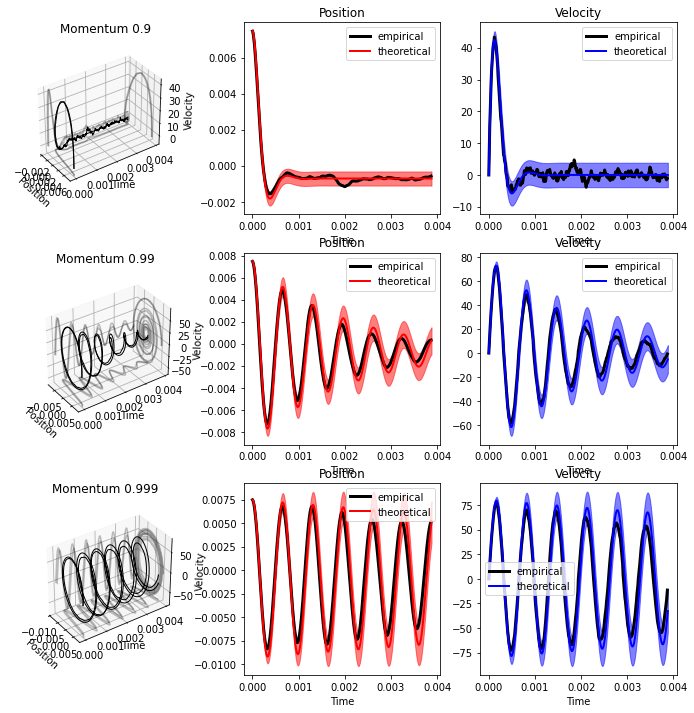

In [27]:
nrows = 3
ncols = 3
fig = plt.figure(figsize=(4 * ncols, 4 * nrows))

lr = 1e-5
wd = 0
bs = 512
momentums = [0.9, 0.99, 0.999]
exp_kwargs["experiment"] = "linear_regression"
for i, momentum in enumerate(momentums):
    lr_= f"{lr:1.0e}".replace("-","n")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    exp_kwargs["expid"] = f"cifar10_hessian_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
    weights, grads, eigenvectors, eigenvalues = load_cache(
        expid_eigenvalues="cifar10_hessian_evals", **exp_kwargs
    )
    
    projected_weights, projected_grads = project(weights, grads, eigenvectors, eig_idx)
    
    steps = np.arange(0, projected_weights.shape[0])
    time = lr*np.linspace(0,projected_weights.shape[0],10000)
    mu = np.mean(projected_weights[-100:], axis=0)
    a0 = (projected_weights[0] - mu)
    a, b = mean(eigenvalues[eig_idx], a0, 0, lr, momentum, wd, time)
    b*= -1
    a += mu
    
    sigma = 0.8
    va, vb = variance(eigenvalues[eig_idx], 0.95, sigma, lr, momentum, wd, bs, time)
    
    ax = fig.add_subplot(nrows, ncols, i*ncols + 1, projection='3d')
    phase_3d(ax, projected_weights, projected_grads, time=lr*steps)
    phase_3d(ax, a, b, time=time, color="r")
    ax.set_title(f"Momentum {momentum}")
    
    ax = fig.add_subplot(nrows, ncols, i*ncols + 2)
    ax.plot(lr*steps, projected_weights, lw=3, color='k', label="empirical")
    ax.plot(time, a, lw=2, color='r', label="theoretical")
    ax.fill_between(time, a + va,  a - va, color='r', alpha=0.5)
    ax.set_title('Position')
    ax.set_xlabel('Time')
    ax.legend()
    
    ax = fig.add_subplot(nrows, ncols, i*ncols + 3)
    ax.plot(lr*steps, projected_grads, lw=3, color='k', label="empirical")
    ax.plot(time, b, lw=2, color='b', label="theoretical")
    ax.fill_between(time, b + vb,  b - vb, color='b', alpha=0.5)
    ax.set_title('Velocity')
    ax.set_xlabel('Time')
    ax.legend()

    
plt.savefig("variance.pdf")
plt.show()

# Logistic regression models
## Single layer classification model (CE loss) on Cifar 10

In [ ]:
# This cell generates a big grid, clear the output to avoid a large notebook file
nrows = 6
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows), subplot_kw={"projection":"3d"})

lrs = [0.0001, 0.00001]
wds = [1e-4]
bss = [256,512,1024]
momentums = [0.9, 0.99, 0.999]
eig_idx = 0
k = 0
exp_kwargs["experiment"] = "linear_regression"
for lr,bs,wd,momentum in itertools.product(lrs, bss, wds, momentums):
    lr_= f"{lr:1.0e}".replace("-","n")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    exp_kwargs["expid"] = f"cifar10_hessian_ce_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
    weights, grads, eigenvectors, eigenvalues = load_cache(**exp_kwargs)
    
    projected_weights, projected_grads = project(weights, grads, eigenvectors, eig_idx)
    
    steps = np.arange(0, projected_weights.shape[0])
    time = lr*np.linspace(0,projected_weights.shape[0],10000)
    mu = np.mean(projected_weights[-100:], axis=0)
    a0 = (projected_weights[0] - mu)
    a, b = mean(eigenvalues[eig_idx], a0, 0, lr, momentum, wd, time)
    a += mu
    
    j = k % ncols
    i = k // ncols
    ax = axes[i,j]
    ax.set_title(exp_kwargs["expid"])
    phase_3d(ax, x=projected_weights, v=projected_grads, time=lr*steps,
             xt=a, vt=-b, timet=time)
    k += 1
plt.savefig("spirals_logistic.pdf")
plt.show()

# Nonlinear model sweep

- Rerun sweep above but now with CE loss. 

- Use both MSE and CE loss
- Small models: start with default fc with L=2 on cifar10, L=6 after this one,
  - conv layers lately
- Sweep same hyperparams, least important is wd, focus on smaller LRs

### Fully connected 2 layer model doing regression (MSe loss) on Cifar 10, hyperparam sweep

In [ ]:
# This cell generates a big grid, clear the output to avoid a large notebook file
nrows = 6
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows), subplot_kw={"projection":"3d"})

lrs = [0.0001, 0.00001]
wds = [1e-4]
bss = [256,512,1024]
momentums = [0.9, 0.99, 0.999]
eig_idx = 0
k = 0
b_sign = -np.ones((nrows, ncols))
exp_kwargs["experiment"] = "nonlinear"
for lr,bs,wd,momentum in itertools.product(lrs, bss, wds, momentums):
    lr_= f"{lr:1.0e}".replace("-","n")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    exp_kwargs["expid"] = f"cifar10_fc2_mse_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
    weights, grads, eigenvectors, eigenvalues = load_cache(
        expid_eigenvalues=f"{exp_kwargs['expid']}_evals", **exp_kwargs
    )
    
    projected_weights, projected_grads = project(weights, grads, eigenvectors, eig_idx)
    
    steps = np.arange(0, projected_weights.shape[0])
    time = lr*np.linspace(0,projected_weights.shape[0],10000)
    mu = np.mean(projected_weights[-100:], axis=0)
    a0 = (projected_weights[0] - mu)
    a, b = mean(eigenvalues[eig_idx], a0, lr, momentum, wd, time)
    a += mu
    
    j = k % ncols
    i = k // ncols
    ax = axes[i,j]
    ax.set_title(exp_kwargs["expid"])
    phase_3d(ax, x=projected_weights, v=projected_grads, time=lr*steps,
             xt=a, vt=b_sign[i,j]*b, timet=time)
    k += 1
plt.savefig("spirals_fc2_mse.pdf")
plt.show()

### Fully connected 2 layer model doing classification on Cifar 10, hyperparam sweep

In [ ]:
# This cell generates a big grid, clear the output to avoid a large notebook file
nrows = 6
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows), subplot_kw={"projection":"3d"})

lrs = [0.0001, 0.00001]
wds = [1e-4]
bss = [256,512,1024]
momentums = [0.9, 0.99, 0.999]
eig_idx = 0
k = 0
b_sign = -np.ones((nrows, ncols))
exp_kwargs["experiment"] = "nonlinear"
for lr,bs,wd,momentum in itertools.product(lrs, bss, wds, momentums):
    lr_= f"{lr:1.0e}".replace("-","n")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    exp_kwargs["expid"] = f"cifar10_fc2_ce_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
    weights, grads, eigenvectors, eigenvalues = load_cache(
        expid_eigenvalues=f"{exp_kwargs['expid']}_evals", **exp_kwargs
    )
    
    projected_weights, projected_grads = project(weights, grads, eigenvectors, eig_idx)
    
    steps = np.arange(0, projected_weights.shape[0])
    time = lr*np.linspace(0,projected_weights.shape[0],10000)
    mu = np.mean(projected_weights[-100:], axis=0)
    a0 = (projected_weights[0] - mu)
    a, b = mean(eigenvalues[eig_idx], a0, lr, momentum, wd, time)
    a += mu
    
    j = k % ncols
    i = k // ncols
    ax = axes[i,j]
    ax.set_title(exp_kwargs["expid"])
    phase_3d(ax, x=projected_weights, v=projected_grads, time=lr*steps,
             xt=a, vt=b_sign[i,j]*b, timet=time)
    k += 1
plt.savefig("spirals_fc2_ce.pdf")
plt.show()

### Just a subset from the above cell, no theory

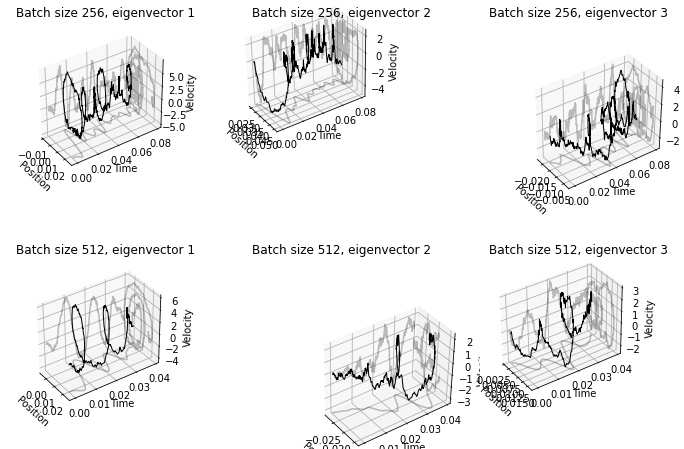

In [10]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), subplot_kw={"projection":"3d"})

lrs = [0.0001]
wds = [1e-4]
bss = [256,512]
momentums = [0.99]
eigs = [0,1,2]
k = 0
b_sign = -np.ones((nrows, ncols))
exp_kwargs["experiment"] = "nonlinear"
for lr,bs,wd,momentum, eig_idx in itertools.product(lrs, bss, wds, momentums, eigs):
    lr_= f"{lr:1.0e}".replace("-","n")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    exp_kwargs["expid"] = f"cifar10_fc2_ce_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
    weights, grads, eigenvectors, eigenvalues = load_cache(expid_eigenvalues=f"{exp_kwargs['expid']}_evals", **exp_kwargs)
    
    projected_weights, projected_grads = project(weights, grads, eigenvectors, eig_idx)
    
    steps = np.arange(0, projected_weights.shape[0])
    time = lr*np.linspace(0,projected_weights.shape[0],10000)
    mu = np.mean(projected_weights[-100:], axis=0)
    a0 = (projected_weights[0] - mu)
    a, b = mean(eigenvalues[eig_idx], a0, 0, lr, momentum, wd, time)
    a += mu
    
    j = k % ncols
    i = k // ncols
    ax = axes[i,j]
    ax.set_title(f"Batch size {bs}, eigenvector {eig_idx+1}")
    phase_3d(ax, x=projected_weights, v=projected_grads, time=lr*steps)
    k += 1
plt.savefig("spirals_fc2_eigsweep.pdf")
plt.show()

# TODO: 04.23.21
- Sweep of starring position to fit theory and empiric trajs
- Scaling empirics up to deeper nets and larger datasets (independently) smallest vgg no bn train form beginning
- Pioritize this tradeoff thing

In [ ]:
def traj_mse(empirical_a, empirical_b, time_start, lr, momentum, wd, eigenvalues, eig_idx=0):
    a = None
    b = None
    time = lr*np.linspace(0,empirical_a.shape[0]-time_start, empirical_a.shape[0]-time_start)
    mu = np.mean(empirical_a[-100:], axis=0)
    a0 = (empirical_a[time_start] - mu)
    b0 = -empirical_b[time_start]
    a, b = mean(eigenvalues[eig_idx], a0, b0, lr, momentum, wd, time)
    a += mu
    time += lr*time_start

    assert(np.allclose(a[0], empirical_a[time_start], atol=1e-8))
    assert(np.allclose(b[0], -empirical_b[time_start], atol=1e-8))
    
    mse = ((a - empirical_a[time_start:])**2).mean()
    return mse, (time, a, b)
    

### Linear Regression on Cifar 100, hyperparam sweep

In [ ]:
# This cell generates a big grid, clear the output to avoid a large notebook file
nrows = 6
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows), subplot_kw={"projection":"3d"})
fig_mse, axes_mse = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))

lrs = [0.0001, 0.00001]
wds = [1e-4]
bss = [256,512,1024]
momentums = [0.9, 0.99, 0.999]
eig_idx = 0
k = 0
exp_kwargs["experiment"] = "linear_regression"
for lr,bs,wd,momentum in itertools.product(lrs, bss, wds, momentums):
    lr_= f"{lr:1.0e}".replace("-","n")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    exp_kwargs["expid"] = f"cifar10_hessian_ce_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
    weights, grads, eigenvectors, eigenvalues = load_cache(**exp_kwargs)
    
    projected_weights, projected_grads = project(weights, grads, eigenvectors, eig_idx)
    
    steps = np.arange(0, projected_weights.shape[0])
    
    mse_min = 10000
    mses = []
    for time_idx in range(projected_weights.shape[0]//2):
        mse,_ = traj_mse(projected_weights, projected_grads, time_idx, lr, momentum, wd, eigenvalues, eig_idx=0)
        
        if mse < mse_min:
            mse_min = mse
            timet_start = time_idx
        mses.append((time_idx, mse))
                
    _, (time, a, b) = traj_mse(projected_weights, projected_grads, timet_start, lr, momentum, wd, eigenvalues, eig_idx=0)
    
    j = k % ncols
    i = k // ncols
    ax = axes[i,j]
    ax.set_title(exp_kwargs["expid"])
    phase_3d(ax, x=projected_weights, v=projected_grads, time=lr*steps,
             xt=a, vt=-b, timet=time)
    
    # Plot the MSES over time
    mse_time = [m[0] for m in mses]
    mse_traj = [m[1] for m in mses]
    axes_mse[i,j].plot(mse_time, mse_traj)
    axes_mse[i,j].plot(mse_time[timet_start], mse_min, "ro")
    axes_mse[i,j].set_xlabel("Time idx")
    axes_mse[i,j].set_ylabel("MSE")
    axes_mse[i,j].set_title(exp_kwargs["expid"])
    k += 1
fig.savefig("spirals_logistic_fitted.pdf")
fig.show()
fig_mse.savefig("spirals_logistic_fitted_mse.pdf")
fig_mse.show()

### Fully connected 2 layer model doing regression (MSE loss) on Cifar 100, hyperparam sweep

In [ ]:
# This cell generates a big grid, clear the output to avoid a large notebook file
nrows = 6
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows), subplot_kw={"projection":"3d"})
fig_mse, axes_mse = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))

lrs = [0.0001, 0.00001]
wds = [1e-4]
bss = [256,512,1024]
momentums = [0.9, 0.99, 0.999]
eig_idx = 0
k = 0
b_sign = -np.ones((nrows, ncols))
exp_kwargs["experiment"] = "nonlinear"
for lr,bs,wd,momentum in itertools.product(lrs, bss, wds, momentums):
    lr_= f"{lr:1.0e}".replace("-","n")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    exp_kwargs["expid"] = f"cifar10_fc2_mse_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
    weights, grads, eigenvectors, eigenvalues = load_cache(expid_eigenvalues=f"{exp_kwargs['expid']}_evals", **exp_kwargs)
    
    projected_weights, projected_grads = project(weights, grads, eigenvectors, eig_idx)
    
    steps = np.arange(0, projected_weights.shape[0])
    
    mse_min = 10000
    mses = []
    for time_idx in range(projected_weights.shape[0]//2):
        mse,_ = traj_mse(projected_weights, projected_grads, time_idx, lr, momentum, wd, eigenvalues, eig_idx=0)
        
        if mse < mse_min:
            mse_min = mse
            timet_start = time_idx
        mses.append((time_idx, mse))
                
    _, (time, a, b) = traj_mse(projected_weights, projected_grads, timet_start, lr, momentum, wd, eigenvalues, eig_idx=0)
    
    
    j = k % ncols
    i = k // ncols
    ax = axes[i,j]
    ax.set_title(exp_kwargs["expid"])
    phase_3d(ax, x=projected_weights, v=projected_grads, time=lr*steps,
             xt=a, vt=b_sign[i,j]*b, timet=time)
    
    # Plot the MSES over time
    mse_time = [m[0] for m in mses]
    mse_traj = [m[1] for m in mses]
    axes_mse[i,j].plot(mse_time, mse_traj)
    axes_mse[i,j].plot(mse_time[timet_start], mse_min, "ro")
    axes_mse[i,j].set_xlabel("Time idx")
    axes_mse[i,j].set_ylabel("MSE")
    axes_mse[i,j].set_title(exp_kwargs["expid"])
    
    k += 1
fig.savefig("spirals_fc2_mse.pdf")
fig.show()
fig_mse.savefig("spirals_fc2_fitted_mse.pdf")
fig_mse.show()

### Fully connected 2 layer model doing classification (CE loss) on Cifar 100, hyperparam sweep

In [ ]:
# This cell generates a big grid, clear the output to avoid a large notebook file
nrows = 6
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows), subplot_kw={"projection":"3d"})
fig_mse, axes_mse = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))

lrs = [0.0001, 0.00001]
wds = [1e-4]
bss = [256,512,1024]
momentums = [0.9, 0.99, 0.999]
eig_idx = 0
k = 0
b_sign = -np.ones((nrows, ncols))
exp_kwargs["experiment"] = "nonlinear"
for lr,bs,wd,momentum in itertools.product(lrs, bss, wds, momentums):
    lr_= f"{lr:1.0e}".replace("-","n")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    exp_kwargs["expid"] = f"cifar10_fc2_ce_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
    weights, grads, eigenvectors, eigenvalues = load_cache(expid_eigenvalues=f"{exp_kwargs['expid']}_evals", **exp_kwargs)
    
    projected_weights, projected_grads = project(weights, grads, eigenvectors, eig_idx)
    
    steps = np.arange(0, projected_weights.shape[0])
    
    mse_min = 10000
    mses = [de]
    for time_idx in range(projected_weights.shape[0]//2):
        mse,_ = traj_mse(projected_weights, projected_grads, time_idx, lr, momentum, wd, eigenvalues, eig_idx=0)
        
        if mse < mse_min:
            mse_min = mse
            timet_start = time_idx
        mses.append((time_idx, mse))
                
    _, (time, a, b) = traj_mse(projected_weights, projected_grads, timet_start, lr, momentum, wd, eigenvalues, eig_idx=0)
    
    
    j = k % ncols
    i = k // ncols
    ax = axes[i,j]
    ax.set_title(exp_kwargs["expid"])
    phase_3d(ax, x=projected_weights, v=projected_grads, time=lr*steps,
             xt=a, vt=b_sign[i,j]*b, timet=time)
    
    # Plot the MSES over time
    mse_time = [m[0] for m in mses]
    mse_traj = [m[1] for m in mses]
    axes_mse[i,j].plot(mse_time, mse_traj)
    axes_mse[i,j].plot(mse_time[timet_start], mse_min, "ro")
    axes_mse[i,j].set_xlabel("Time idx")
    axes_mse[i,j].set_ylabel("MSE")
    axes_mse[i,j].set_title(exp_kwargs["expid"])
    
    k += 1
fig.savefig("spirals_fc2_fitted_ce.pdf")
fig.show()
fig_mse.savefig("spirals_fc2_fitted_ce_msetraj.pdf")
fig_mse.show()

In [11]:
def load_cache_new(experiment="hessian", expid="imagenet_pret_ce", subdir="", suffix=""):
    PT_CACHE_DIR = f"/mnt/fs6/jvrsgsty/neural-mechanics{subdir}"
    cache_dir = f"{PT_CACHE_DIR}/{experiment}/{expid}/cache/hessian_eigenprojection{suffix}.h5"
    projected_weights = dd.io.load(cache_dir, f"/projected_weights")
    projected_grads = dd.io.load(cache_dir, f"/projected_grads")
    eigenvectors = dd.io.load(cache_dir, f"/eigenvectors")
    eigenvalues = dd.io.load(cache_dir, f"/eigenvalues")
    return projected_weights, projected_grads, eigenvectors, eigenvalues


### Deep Network (VGG11) model doing regression (MSE loss) on Cifar 100, hyperparam sweep

In [ ]:
nrows = 6
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows), subplot_kw={"projection":"3d"})
fig_mse, axes_mse = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))

lrs = [0.1, 0.01]
wds = [1e-4]
bss = [256,512,1024]
momentums = [0.9, 0.99, 0.999]
eig_idx = 14
k = 0
b_sign = -np.ones((nrows, ncols))
exp_kwargs["experiment"] = "nonlinear"
for lr,bs,wd,momentum in itertools.product(lrs, bss, wds, momentums):
    lr_= f"{lr:1.0e}".replace("-","n")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    exp_kwargs["expid"] = f"cifar10_vgg11_mse_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
    
    projected_weights, projected_grads, eigenvectors, eigenvalues = load_cache_new(
        exp_kwargs["experiment"], exp_kwargs["expid"]
    )
    projected_weights = projected_weights[:,eig_idx]
    projected_grads = projected_grads[:,eig_idx]
    
    steps = np.arange(0, projected_weights.shape[0])
    
    mse_min = 10000
    mses = []
    timet_start = 0
    for time_idx in range(0):
        mse,_ = traj_mse(
            projected_weights, projected_grads, 
            time_idx, lr, momentum, wd, 
            eigenvalues, eig_idx=0
        )
        
        if mse < mse_min:
            mse_min = mse
            timet_start = time_idx
        mses.append((time_idx, mse))
                
    _, (time, a, b) = traj_mse(
        projected_weights, projected_grads, 
        timet_start, lr, momentum, wd, 
        eigenvalues, eig_idx=0
    )
    
    
    j = k % ncols
    i = k // ncols
    ax = axes[i,j]
    ax.set_title(exp_kwargs["expid"])
    phase_3d(ax, x=projected_weights, v=projected_grads, time=lr*steps,
             xt=a, vt=-b, timet=time)
    
    # Plot the MSES over time
    if len(mses) > 0:
        mse_time = [m[0] for m in mses]
        mse_traj = [m[1] for m in mses]
        axes_mse[i,j].plot(mse_time, mse_traj)
        axes_mse[i,j].plot(mse_time[timet_start], mse_min, "ro")
        axes_mse[i,j].set_xlabel("Time idx")
        axes_mse[i,j].set_ylabel("MSE")
        axes_mse[i,j].set_title(exp_kwargs["expid"])
    
    k += 1
#fig.savefig("spirals_fc2_fitted_mse.pdf")
#fig.show()

## Pretrained VGG11 on Imagenet

In [ ]:
exp_kwargs = {
    "experiment": "pretrained_imagenet",
    "expid": "vgg11_ce",
    "save-dir": "gs://jv_neural_mechanics",
    "dataset": "imagenet",
    "data-dir": "/home/jvrsgsty/data",
    "model-dir": "/home/jvrsgsty/models",
    "pretrained": True,
    "model": "vgg11",
    "model-class": "imagenet",
    "loss": "ce",
    "optimizer": "custom_sgd",
    "test-batch-size": 256,
    "epochs": 3,
    "save-freq": 1, 
    "save-begin-epoch": 2.75,
    "eigenvector": True,
    "eigen-batch-size": 16,
    "eigen-data-length": 50000,
    "power-iters": 10,
    "eigen-dims": 15,
    # Sweep ofer these
    "train-batch-size": 32,
    "lr": 1e-5,
    "wd": 5e-4,
    "momentum": 0.9,
    "gpu": "1",
}
flags = ["overwrite"]
print(create_args_string(exp_kwargs, flags))

### Deep NN (VGG11, pretrained on imagenet) doing classification on Cifar 100, hyperparam sweep

CUDA_VISIBLE_DEVICES=1 python train.py --experiment pretrained_imagenet --expid vgg11_ce_evals --save-dir /mnt/fs6/jvrsgsty/neural_mechanics/jv_neural_mechanics --dataset imagenet --data-dir /data/jvrsgsty/Dataset --model-dir /home/jvrsgsty/models --model vgg11 --model-class imagenet --loss ce --optimizer custom_sgd --test-batch-size 256 --epochs 0 --save-freq 1 --save-begin-epoch 2.75 --eigenvector True --eigen-batch-size 128 --eigen-data-length 50000 --power-iters 10 --eigen-dims 15 --train-batch-size 256 --lr 1e-05 --wd 0.0005 --momentum 0.9 --gpu 0 --overwrite -v --restore-path /mnt/fs6/jvrsgsty/pretrained_models/vgg11_imnet_ce_s14198.tar

CUDA_VISIBLE_DEVICES=4,5 python train.py --experiment pretrained_imagenet --expid vgg11_mse_evals --save-dir /mnt/fs6/jvrsgsty/neural_mechanics/jv_neural_mechanics --dataset imagenet --data-dir /data/jvrsgsty/Dataset --model-dir /home/jvrsgsty/models --model vgg11 --model-class imagenet --loss mse --optimizer custom_sgd --test-batch-size 256 --epochs 0 --save-freq 1 --save-begin-epoch 2.75 --eigenvector True --eigen-batch-size 128 --eigen-data-length 50000 --power-iters 10 --eigen-dims 15 --train-batch-size 32 --lr 1e-05 --wd 0.0005 --momentum 0.9 --gpu 0 --overwrite -v --restore-path /mnt/fs6/jvrsgsty/pretrained_models/vgg11_imnet_mse_s14206.tar

CUDA_VISIBLE_DEVICES=9 python extract_pos_vel.py --experiment pretrained_imagenet --expid vgg11_ce --save-dir /mnt/fs6/jvrsgsty/neural_mechanics/jv_neural_mechanics --gpu 0 --overwrite

CUDA_VISIBLE_DEVICES=9 python extract_pos_vel.py --experiment pretrained_imagenet --expid vgg11_mse --save-dir /mnt/fs6/jvrsgsty/neural_mechanics/jv_neural_mechanics --gpu 0 --overwrite -v

In [ ]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 12 * nrows), subplot_kw={"projection":"3d"})
fig_mse, axes_mse = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))

lr = 1e-5
wd = 5e-4
bs = 256
momentum = 0.9
eig_idx = 2

exp_kwargs["experiment"] = "pretrained_imagenet"

exp_kwargs["expid"] = f"vgg11_ce"

projected_weights, projected_grads, eigenvectors, eigenvalues = load_cache_new(
    exp_kwargs["experiment"], exp_kwargs["expid"], subdir="/jv_neural_mechanics")
projected_weights = projected_weights[:,eig_idx]
projected_grads = projected_grads[:,eig_idx]

steps = np.arange(0, projected_weights.shape[0])

mse_min = 10000
mses = []
timet_start = 0
for time_idx in range(0):
    mse,_ = traj_mse(projected_weights, projected_grads, time_idx, lr, momentum, wd, eigenvalues, eig_idx=0)

    if mse < mse_min:
        mse_min = mse
        timet_start = time_idx
    mses.append((time_idx, mse))

_, (time, a, b) = traj_mse(projected_weights, projected_grads, timet_start, lr, momentum, wd, eigenvalues, eig_idx=0)



ax = axes
ax.set_title(exp_kwargs["expid"])
phase_3d(ax, x=projected_weights, v=projected_grads, time=lr*steps,
         xt=a, vt=-b, timet=time)

# Plot the MSES over time
if len(mses) > 0:
    mse_time = [m[0] for m in mses]
    mse_traj = [m[1] for m in mses]
    axes_mse.plot(mse_time, mse_traj)
    axes_mse.plot(mse_time[timet_start], mse_min, "ro")
    axes_mse.set_xlabel("Time idx")
    axes_mse.set_ylabel("MSE")
    axes_mse.set_title(exp_kwargs["expid"])


CUDA_VISIBLE_DEVICES=1 python train.py --experiment pretrained_imagenet --expid rest18_pretrained_initial_evals --save-dir /mnt/fs6/jvrsgsty/neural-mechanics/jv_neural_mechanics --dataset imagenet --data-dir /data/jvrsgsty/Dataset --model-dir /home/jvrsgsty/models --model resnet18 --model-class imagenet --loss ce --optimizer custom_sgd --test-batch-size 256 --epochs 0 --save-freq 1 --save-begin-epoch 2.875 --eigenvector True --eigen-batch-size 128 --eigen-data-length 40000 --power-iters 10 --eigen-dims 10 --train-batch-size 256 --lr 1e-04 --wd 0.0001 --momentum 0.9 --gpu 0 --overwrite -v --pretrained True

CUDA_VISIBLE_DEVICES=0 python train.py --experiment pretrained_imagenet --expid rest18_mom9 --save-dir /mnt/fs6/jvrsgsty/neural-mechanics/jv_neural_mechanics --dataset imagenet --data-dir /data/jvrsgsty/Dataset --model-dir /home/jvrsgsty/models --model resnet18 --model-class imagenet --loss ce --optimizer custom_sgd --test-batch-size 256 --epochs 3 --save-freq 1 --save-begin-epoch 2.875 --train-batch-size 256 --lr 1e-04 --wd 0.0001 --momentum 0.9 --gpu 0 --overwrite -v --pretrained True

CUDA_VISIBLE_DEVICES=2 python train.py --experiment pretrained_imagenet --expid rest18_mom99 --save-dir /mnt/fs6/jvrsgsty/neural-mechanics/jv_neural_mechanics --dataset imagenet --data-dir /data/jvrsgsty/Dataset --model-dir /home/jvrsgsty/models --model resnet18 --model-class imagenet --loss ce --optimizer custom_sgd --test-batch-size 256 --epochs 3 --save-freq 1 --save-begin-epoch 2.875 --train-batch-size 256 --lr 1e-04 --wd 0.0001 --momentum 0.99 --gpu 0 --overwrite -v --pretrained True

CUDA_VISIBLE_DEVICES=3 python train.py --experiment pretrained_imagenet --expid rest18_mom999 --save-dir /mnt/fs6/jvrsgsty/neural-mechanics/jv_neural_mechanics --dataset imagenet --data-dir /data/jvrsgsty/Dataset --model-dir /home/jvrsgsty/models --model resnet18 --model-class imagenet --loss ce --optimizer custom_sgd --test-batch-size 256 --epochs 3 --save-freq 1 --save-begin-epoch 2.875 --train-batch-size 256 --lr 1e-04 --wd 0.0001 --momentum 0.999 --gpu 0 --overwrite -v --pretrained True


CUDA_VISIBLE_DEVICES=1 python train.py --experiment pretrained_imagenet --expid rest18_momn1 --save-dir /mnt/fs6/jvrsgsty/neural-mechanics/jv_neural_mechanics --dataset imagenet --data-dir /data/jvrsgsty/Dataset --model-dir /home/jvrsgsty/models --model resnet18 --model-class imagenet --loss ce --optimizer custom_sgd --test-batch-size 256 --epochs 10 --save-freq 500 --train-batch-size 256 --lr 1e-04 --wd 0.0001 --momentum -1 --gpu 0 --overwrite -v --pretrained True

CUDA_VISIBLE_DEVICES=3 python train.py --experiment pretrained_imagenet --expid rest18_momn9 --save-dir /mnt/fs6/jvrsgsty/neural-mechanics/jv_neural_mechanics --dataset imagenet --data-dir /data/jvrsgsty/Dataset --model-dir /home/jvrsgsty/models --model resnet18 --model-class imagenet --loss ce --optimizer custom_sgd --test-batch-size 256 --epochs 10 --save-freq 500 --train-batch-size 256 --lr 1e-04 --wd 0.0001 --momentum -0.9 --gpu 0 --overwrite -v --pretrained True





In [ ]:
# This cell generates a big grid, clear the output to avoid a large notebook file

nrows = 3
ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 12 * nrows), subplot_kw={"projection":"3d"})
fig2, axes2 = plt.subplots(nrows, ncols, figsize=(12 * ncols, 12 * nrows), subplot_kw={"projection":"3d"})

lr = 1e-5
wd = 5e-4
bs = 256
momentums = [0.9, 0.99, 0.999]
eig_idx = 0

exp_kwargs["experiment"] = "pretrained_imagenet"

for i,momentum in enumerate(momentums):
    for j in range(5):
        eig_idx  = j
        exp_kwargs["expid"] = f"rest18_mom{str(momentum).split('.')[1]}"

        projected_weights, projected_grads, eigenvectors, eigenvalues = load_cache_new(
            exp_kwargs["experiment"], exp_kwargs["expid"], 
            subdir="/jv_neural_mechanics", suffix="_10eig_10it_40k")
        projected_weights = projected_weights[:,eig_idx]
        projected_grads = projected_grads[:,eig_idx]

        steps = np.arange(0, projected_weights.shape[0])

        ax = axes[i,j]
        ax.set_title(exp_kwargs["expid"])
        phase_3d(ax, x=projected_weights[3:], v=projected_grads[3:], time=lr*steps[3:],
                 xt=None, vt=None, timet=None)
        
        
        exp_kwargs["expid"] = f"rest18_mom{str(momentum).split('.')[1]}"

        projected_weights, projected_grads, eigenvectors, eigenvalues = load_cache_new(
            exp_kwargs["experiment"], exp_kwargs["expid"], subdir="/jv_neural_mechanics")
        projected_weights = projected_weights[:,eig_idx]
        projected_grads = projected_grads[:,eig_idx]
        
        ax = axes2[i,j]
        ax.set_title(exp_kwargs["expid"])
        phase_3d(ax, x=projected_weights[3:], v=projected_grads[3:], time=lr*steps[3:],
                 xt=None, vt=None, timet=None)

In [ ]:
eigenvalues

In [ ]:
# This cell generates a big grid, clear the output to avoid a large notebook file
nrows = 15
ncols = 3
fig, axes = plt.subplots(nrows-5, ncols, figsize=(12 * ncols, 12 * (nrows-5)), subplot_kw={"projection":"3d"})
fig2, axes2 = plt.subplots(nrows, ncols, figsize=(12 * ncols, 12 * nrows), subplot_kw={"projection":"3d"})

lr = 1e-5
wd = 5e-4
bs = 256
momentums = [0.9, 0.99, 0.999]
eig_idx = 0

exp_kwargs["experiment"] = "pretrained_imagenet"

for i,momentum in enumerate(momentums):
    for j in range(15):
        eig_idx  = j
        exp_kwargs["expid"] = f"rest18_mom{str(momentum).split('.')[1]}"
        if(j <10):
            projected_weights, projected_grads, eigenvectors, eigenvalues = load_cache_new(
                exp_kwargs["experiment"], exp_kwargs["expid"], 
                subdir="/jv_neural_mechanics", suffix="_10eig_10it_40k")
            projected_weights = projected_weights[:,eig_idx]
            projected_grads = projected_grads[:,eig_idx]

            steps = np.arange(0, projected_weights.shape[0])
        
            ax = axes[j,i]
            ax.set_title(exp_kwargs["expid"])
            phase_3d(ax, x=projected_weights[3:], v=projected_grads[3:], time=lr*steps[3:],
                     xt=None, vt=None, timet=None)
        
        
        exp_kwargs["expid"] = f"rest18_mom{str(momentum).split('.')[1]}"

        projected_weights, projected_grads, eigenvectors, eigenvalues = load_cache_new(
            exp_kwargs["experiment"], exp_kwargs["expid"], subdir="/jv_neural_mechanics")
        projected_weights = projected_weights[:,eig_idx]
        projected_grads = projected_grads[:,eig_idx]
        
        ax = axes2[j,i]
        ax.set_title(exp_kwargs["expid"])
        phase_3d(ax, x=projected_weights[3:], v=projected_grads[3:], time=lr*steps[3:],
                 xt=None, vt=None, timet=None)

fig.savefig("res18_momsweep_smallhess.pdf")  
fig2.savefig("res18_momsweep_largehess.pdf")  


In [22]:
from mpl_toolkits.mplot3d import axes3d
class MyAxes3D(axes3d.Axes3D):

    def __init__(self, baseObject, sides_to_draw):
        self.__class__ = type(baseObject.__class__.__name__,
                              (self.__class__, baseObject.__class__),
                              {})
        self.__dict__ = baseObject.__dict__
        self.sides_to_draw = list(sides_to_draw)
        self.mouse_init()

    def set_some_features_visibility(self, visible):
        for t in self.w_zaxis.get_ticklines() + self.w_zaxis.get_ticklabels():
            t.set_visible(visible)
        self.w_zaxis.line.set_visible(visible)
        self.w_zaxis.pane.set_visible(visible)
        self.w_zaxis.label.set_visible(visible)

    def draw(self, renderer):
        # set visibility of some features False 
        self.set_some_features_visibility(False)
        # draw the axes
        super(MyAxes3D, self).draw(renderer)
        # set visibility of some features True. 
        # This could be adapted to set your features to desired visibility, 
        # e.g. storing the previous values and restoring the values
        self.set_some_features_visibility(True)

        zaxis = self.zaxis
        draw_grid_old = zaxis.axes._draw_grid
        # disable draw grid
        zaxis.axes._draw_grid = False

        tmp_planes = zaxis._PLANES

        if 'l' in self.sides_to_draw :
            # draw zaxis on the left side
            zaxis._PLANES = (tmp_planes[2], tmp_planes[3],
                             tmp_planes[0], tmp_planes[1],
                             tmp_planes[4], tmp_planes[5])
            zaxis.draw(renderer)
        if 'r' in self.sides_to_draw :
            # draw zaxis on the right side
            zaxis._PLANES = (tmp_planes[3], tmp_planes[2], 
                             tmp_planes[1], tmp_planes[0], 
                             tmp_planes[4], tmp_planes[5])
            zaxis.draw(renderer)

        zaxis._PLANES = tmp_planes

        # disable draw grid
        zaxis.axes._draw_grid = draw_grid_old

def phase_3d_polished(ax, x, v, time, xt=None, vt=None, timet=None, w=None, color="k"):
    min_x = min(x)
    min_v = min(v)
    max_time = max(time)
    
    if w is not None:
        noisy_x = x[(w-1)//2:-(w-1)//2]
        noisy_v = v[(w-1)//2:-(w-1)//2]
        time = time[(w-1)//2:-(w-1)//2]
        x = np.convolve(x, np.ones(w), "valid") / w
        v = np.convolve(v, np.ones(w), "valid") / w
        
    k = len(x)
    if xt is not None:
        kt = len(xt)
    
    # Empirical
    ax.plot(x, time, v, lw=2, color="k")
    ax.plot(x, time, min_v * np.ones(k), color="k", alpha=0.4) # position projection
    ax.plot(min_x * np.ones(k), time, v, color="k", alpha=0.4) # velocity projection
    #ax.plot(x[-k:], max_time*np.ones(k), v[-k:], color="k", alpha=0.25) # Phase portrait
    if w is not None:
        ax.plot(noisy_x, time, min_v * np.ones(k), color="k", alpha=0.2, lw=2) # position projection
        ax.plot(min_x * np.ones(k), time, noisy_v, color="k", alpha=0.2, lw=2) # velocity projection
    
    # Theory
    if xt is not None and vt is not None and timet is not None:
        ax.plot(xt, timet, vt, lw=1, color="r")
        ax.plot(xt, timet, min_v * np.ones(kt), color="r", alpha=0.25)
        ax.plot(min_x * np.ones(kt), timet, vt, color="r", alpha=0.25)
        #ax.plot(xt, max_time*np.ones(kt), vt, color="r", alpha=0.25)
    
    # Labels
    #ax.set_xlabel("Position")
    #ax.set_ylabel("Time")
    #ax.set_zlabel("Velocity")
    ax.view_init(elev=35.0, azim=-45)
    # This line just scales the axis in the figure: x,y,z,1.0 by the constants in the np.diag
    # Unsure why we have 0.75 in the last component
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 2, 1.5, 2]))
    
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
    ax.zaxis.set_tick_params(which="both", reset=True, bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out',length=7,width=1.5,pad=8,
                   labelsize=18)
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax.yaxis.set_tick_params(which="both", reset=True, bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out',length=7,width=1.5,pad=5,
                   labelsize=18)
    ax.yaxis.set_major_locator(plt.MaxNLocator(8))
    
    ax.xaxis.set_tick_params(which="both", reset=True,
                   labelbottom=True,
                   labelleft=True, direction='out',length=100,width=20,pad=5,
                   labelsize=18)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    
    
    # boundary
    for axs in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
        axs.line.set_linewidth(3)


    #plt.tight_layout()
    # plt.savefig('bias-oscillations-3d.png', format='png', bbox_inches='tight', transparent=True)

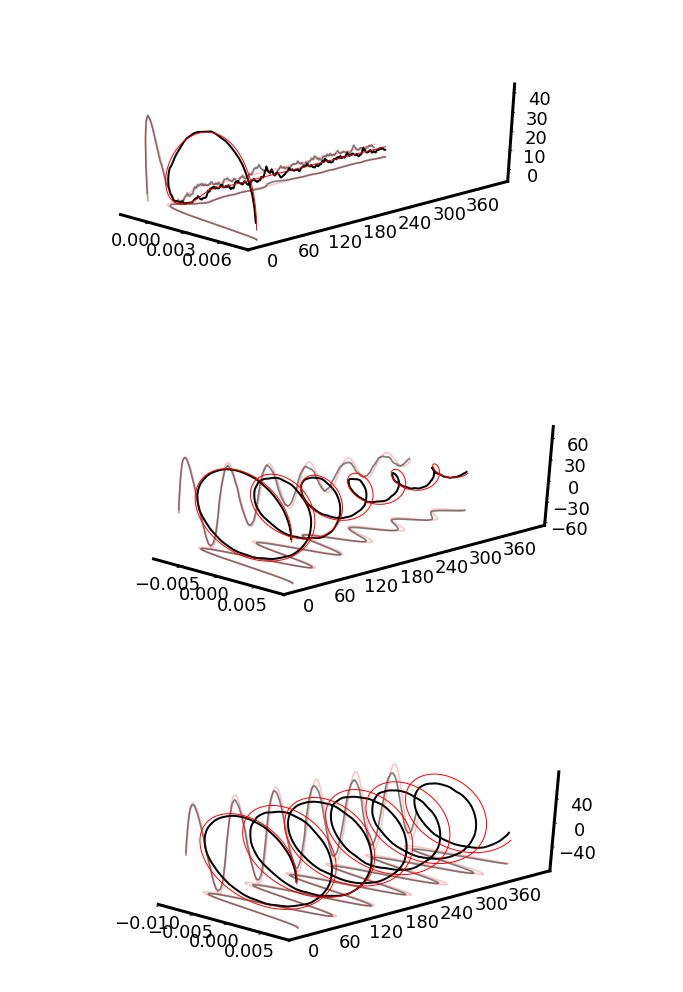

In [19]:
nrows = 3
ncols = 1
l = -2000
k = -1
w = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 6 * nrows), subplot_kw={"projection":"3d"})

lr = 1e-5
wd = 0
bs = 512
momentums = [0.9, 0.99, 0.999]
eig_idx = 0
exp_kwargs['experiment'] =  'linear_regression'
for i, momentum in enumerate(momentums):
    lr_= f"{lr:1.0e}".replace("-","n")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    exp_kwargs["expid"] = f"cifar10_hessian_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
    weights, grads, eigenvectors, eigenvalues = load_cache(
        expid_eigenvalues="cifar10_hessian_evals", **exp_kwargs
    )
    
    projected_weights, projected_grads = project(weights, grads, eigenvectors, eig_idx)
    
    steps = np.arange(0, projected_weights.shape[0])
    time = lr*np.linspace(0,projected_weights.shape[0],10000)
    mu = np.mean(projected_weights[-100:], axis=0)
    a0 = (projected_weights[0] - mu)
    a, b = mean(eigenvalues[eig_idx], a0, 0, lr, momentum, wd, time)
    b*= -1
    a += mu
    
    sigma = 0.8
    va, vb = variance(eigenvalues[eig_idx], 0.95, sigma, lr, momentum, wd, bs, time)
    
    ax = axes[i]
    phase_3d_polished(
        ax, x=projected_weights[l:k], v=projected_grads[l:k], time=np.arange(len(projected_grads[l:k])), 
        xt=a, vt=b, timet=np.linspace(0,projected_weights.shape[0],10000), 
        w=w)
plt.savefig("spirals_linear_regression.pdf")  

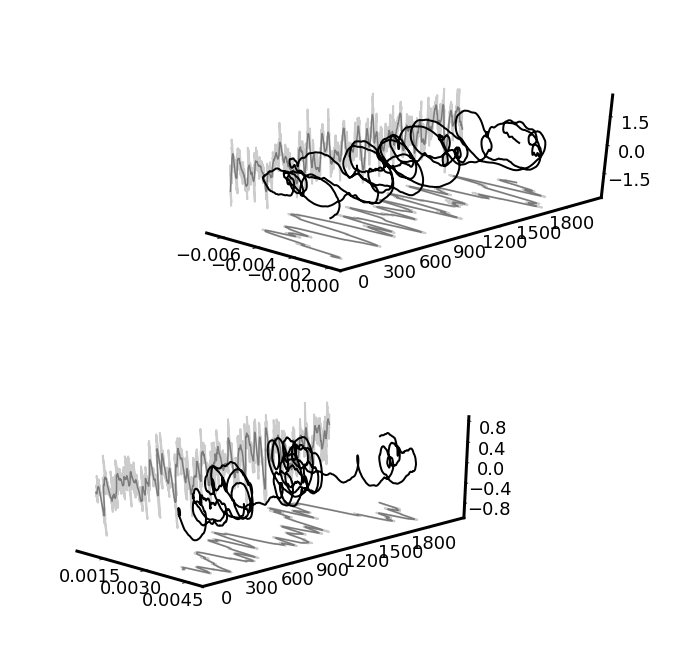

In [23]:
nrows = 2
ncols = 1
l = -2000
k = -1
w = 20

experiment = "loss_grid"
expid = f"trajectory_5epochs"
expid = f"trajectory_5epochs_nojitter"# val performance: 69.30, _ , _ , 69.68, 69.58 , 70 
d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/dist_from_start_from_ckpt.h5", "/dist_from_start")
projected_weights = d["projected_pos"]
projected_grads = d["projected_vel"]


fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 6 * nrows), subplot_kw={"projection":"3d"})
#axes[0] = fig.add_axes(MyAxes3D(axes[0], 'l'))
phase_3d_polished(axes[0], x=projected_weights[l:k,0], v=projected_grads[l:k,0], 
         time=range(len(projected_grads[l:k,0])), w=w)
#axes[1] = fig.add_axes(MyAxes3D(axes[1], 'l'))
phase_3d_polished(axes[1], x=projected_weights[l:k,29], v=projected_grads[l:k,29], 
         time=range(len(projected_grads[l:k,29])), w=w)
plt.savefig("spirals.pdf")